In [52]:
from quantum_svm.quantum.feature_maps import ZZFeatureMap as ZZFeatureMap_custom
from quantum_svm.quantum.kernels import QuantumKernel
from quantum_svm.quantum.quantum_kernels import quantum_kernel
from quantum_svm.quantum.utils import data_map_func_default

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from qiskit import Aer

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Quantum Kernel 
### Validation fof Custom Implementation

In [24]:
# Initialize Random Data
X = np.random.rand(80,2)

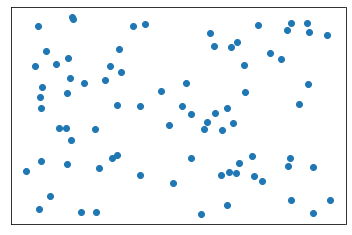

In [25]:
plt.scatter(X[:,0], X[:,1])
plt.xticks([])
plt.yticks([]);

### Custom Implementation with Qiskit Curcuit

In [26]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': None,
}

In [27]:
zz_map_custom = ZZFeatureMap_custom(
    quantum_params['feature_dimension'], 
    quantum_params['reps'], 
    data_map_func_default, 
    insert_barriers=True
)

zz_map_custom

ZZFeatureMap(feature_dimensions=2, reps=2)

In [29]:
backend = Aer.get_backend('qasm_simulator')

zz_kernel = QuantumKernel(feature_map=zz_map_custom, quantum_backend=backend, sim_params=quantum_params)

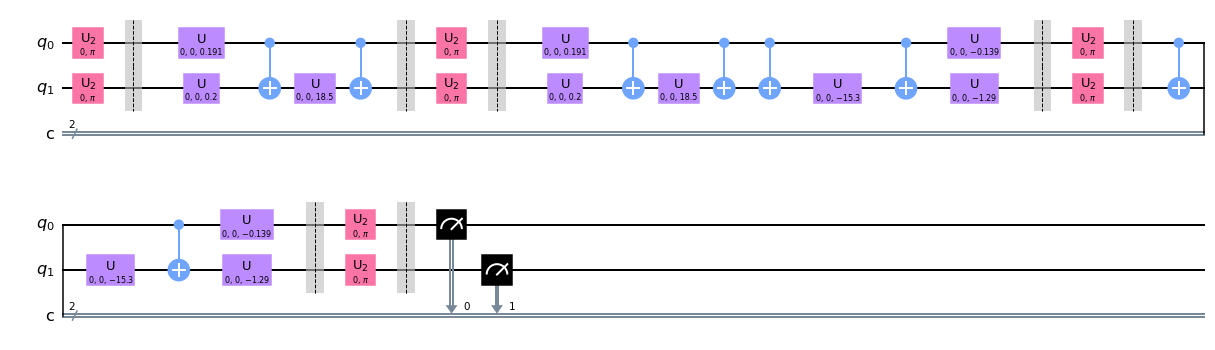

In [32]:
circuit = zz_kernel.construct_circuit(X[0], X[1])
circuit.decompose().decompose().draw('mpl')

In [33]:
QK_custom = zz_kernel.evaluate(X)

### Qiskit Implementation 

/Users/Maxi/.virtualenvs/svm_venv/lib/python3.7/site-packages/sympy/core/expr.py:3951: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  deprecated_since_version="1.9").warn()


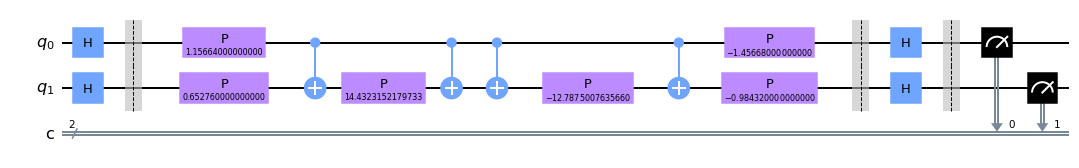

In [40]:
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap

zz_map = ZZFeatureMap(feature_dimension=2, reps=1, entanglement='linear', insert_barriers=True)

zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('qasm_simulator'))

zz_circuit = zz_kernel.construct_circuit(np.array([0.57832, 0.32638]), np.array([0.72834, 0.49216]))
zz_circuit.decompose().decompose().draw(output='mpl')

In [37]:
QK = quantum_kernel(quantum_params)

In [38]:
QK_X = QK(X)

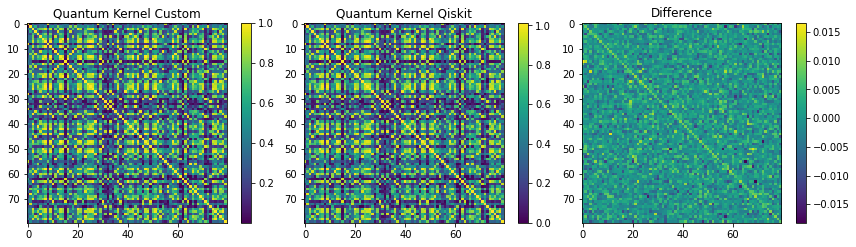

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
im = ax[0].imshow(np.asmatrix(QK_custom),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

ax[0].set_title("Quantum Kernel Custom")
im = ax[1].imshow(np.asmatrix(QK_X),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[1].set_title("Quantum Kernel Qiskit")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

im = ax[2].imshow(QK_X - QK_custom, interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[2].set_title("Difference")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

fig.tight_layout()
plt.show()